The csv file nasdaq100_padding is downloaded from https://github.com/prarora/Dual-Stage-Attention-RNN

Ref: http://chandlerzuo.github.io/blog/2017/11/darnn

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.utils.data as Data

import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [3]:
df = pd.read_csv("nasdaq100_padding.csv") 
print(df.shape)
df.head(3)

(40560, 82)


,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.80,97.80,61.15,95.4000,58.180000,58.00,127.04,26.680,165.8100,...,70.73,45.230,31.1701,95.270,81.365,52.16,33.95,48.61,38.01,4665.054
1,35.9310,96.89,97.80,61.61,95.4115,58.190000,58.12,126.06,26.730,165.9101,...,70.69,45.010,31.1900,94.170,81.540,52.15,34.10,48.74,38.14,4665.054
2,35.9044,96.95,97.57,61.98,95.5100,58.203333,57.95,126.51,26.712,166.1800,...,71.30,45.015,31.2100,94.749,81.530,52.27,34.01,48.99,38.15,4665.826


In [4]:
# NDX as Y, all other features as X
dfY = df['NDX']
dfY.shape

(40560,)

In [5]:
dfX = df.drop(['NDX'], axis=1)
dfX.shape

(40560, 81)

In [6]:
# how many past time series data to consider
TIME_STEPS = 20
BATCH_SIZE = 400

In [7]:
total_rows = len(df.index)
print (total_rows)

40560


In [8]:
xLst = []
yLst = []
for i in range(total_rows - TIME_STEPS):
    xLst1 = dfX[i:i+TIME_STEPS].values.tolist() 
    yLst1 = dfY[i:i+TIME_STEPS].mean()
    xLst.append(xLst1)
    yLst.append(yLst1)

In [9]:
TensorX = torch.FloatTensor(xLst)
TensorY = torch.FloatTensor(yLst)
print(TensorX.shape, TensorY.shape)

torch.Size([40540, 20, 81]) torch.Size([40540])


In [10]:
TensorX = TensorX.view(40540, 81, 20)
print(TensorX.shape)

torch.Size([40540, 81, 20])


In [11]:
TrainX = TensorX[:35000]
TrainY = TensorY[:35000]
print(TrainX.shape, TrainY.shape)

torch.Size([35000, 81, 20]) torch.Size([35000])


In [12]:
TestX = TensorX[35000:]
TestY = TensorY[35000:]
print(TestX.shape, TestY.shape)

torch.Size([5540, 81, 20]) torch.Size([5540])


In [13]:
dataset = Data.TensorDataset(TrainX, TrainY)

In [14]:
loader = Data.DataLoader(
    dataset=dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,       # mini batch size
    shuffle=True,         # random shuffle for training
    num_workers=2,        # subprocesses for loading data
)

# Define LSTM network

In [15]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(81, 128) 
        self.lstm2 = nn.LSTMCell(128, 128)
        self.linear = nn.Linear(128, 1)

    def forward(self, x):
        # input x = (BATCH_SIZE, features, TIME_STEPS), h,c.shape=(BATCH_SIZE, 128)
        h1 = torch.zeros(BATCH_SIZE, 128).to(device) 
        c1 = torch.zeros(BATCH_SIZE, 128).to(device)
        h2 = torch.zeros(BATCH_SIZE, 128).to(device)
        c2 = torch.zeros(BATCH_SIZE, 128).to(device)
        
        # iterate through time steps
        for i in range(TIME_STEPS):
            h1, c1 = self.lstm1(x[:, :, i], (h1, c1))
            h2, c2 = self.lstm2(h1, (h2, c2))
            output = self.linear(h2)
        return output

In [16]:
# build the model
seq = Sequence().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(seq.parameters(), lr=0.005)

In [17]:
seq

Sequence(
  (lstm1): LSTMCell(81, 128)
  (lstm2): LSTMCell(128, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

# If first time, go to Appendix to practice training loop step by step

In [28]:
#begin to train
lossLst = []
for i in range(50):
    epoch_loss = 0.0
    for step, (batch_x, batch_y) in enumerate(loader): 
        # last batch, batch size may be less than BATCH_SIZE
        if(batch_x.size(0) != BATCH_SIZE):
            break;
        VarX, VarY = Variable(batch_x).to(device), Variable(batch_y).to(device)
        VarY = VarY.unsqueeze(dim=1)
        out = seq(VarX)
        loss = criterion(out, VarY)
        epoch_loss += float(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch {}  Loss:{:.2f}".format(i, epoch_loss))
    lossLst.append(epoch_loss)

Epoch 0  Loss:1980783330.00
Epoch 1  Loss:1933576332.00
Epoch 2  Loss:1888228896.00
Epoch 3  Loss:1843993164.00
Epoch 4  Loss:1800604060.00
Epoch 5  Loss:1758047026.00
Epoch 6  Loss:1716269666.00
Epoch 7  Loss:1675227896.00
Epoch 8  Loss:1634917086.00
Epoch 9  Loss:1595274038.00
Epoch 10  Loss:1556309260.00
Epoch 11  Loss:1518103654.00
Epoch 12  Loss:1480455494.00
Epoch 13  Loss:1443552939.00
Epoch 14  Loss:1407204341.00
Epoch 15  Loss:1371525993.00
Epoch 16  Loss:1336440635.00
Epoch 17  Loss:1301993060.00
Epoch 18  Loss:1268079336.00
Epoch 19  Loss:1234793496.00
Epoch 20  Loss:1202110467.00
Epoch 21  Loss:1169965668.00
Epoch 22  Loss:1138417300.00
Epoch 23  Loss:1107386772.00
Epoch 24  Loss:1076903885.00
Epoch 25  Loss:1046997437.00
Epoch 26  Loss:1017574360.00
Epoch 27  Loss:988719538.00
Epoch 28  Loss:960391336.00
Epoch 29  Loss:932552364.00
Epoch 30  Loss:905216280.00
Epoch 31  Loss:878396311.00
Epoch 32  Loss:852093949.00
Epoch 33  Loss:826262232.00
Epoch 34  Loss:800931904.00
Epo

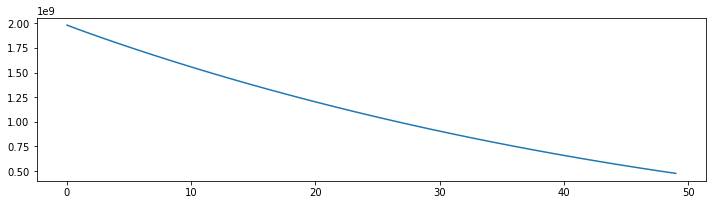

In [29]:
plt.figure(figsize=(12,3))
plt.plot(lossLst)
plt.show()

In [30]:
# try more training epoches without printing
for i in range(40, 200):
    print(i, end=", ")
    epoch_loss = 0.0
    for step, (batch_x, batch_y) in enumerate(loader): 
        if(batch_x.size(0) != BATCH_SIZE):
            break;
        VarX, VarY = Variable(batch_x).to(device), Variable(batch_y).to(device)
        VarY = VarY.unsqueeze(dim=1)
        out = seq(VarX)
        loss = criterion(out, VarY)
        epoch_loss += float(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lossLst.append(epoch_loss)

40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 

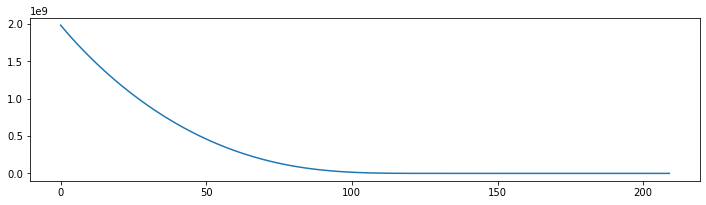

In [31]:
plt.figure(figsize=(12,3))
plt.plot(lossLst)
plt.show()

# Practice -  use test data to test model accuracy

In [ ]:
# Add your code here

# Appendix 
Send a batch of input data to LSTM step by step

In [18]:
for step, (batch_x, batch_y) in enumerate(loader): 
    VarX, VarY = Variable(batch_x).to(device), Variable(batch_y).to(device)
    break
print(VarX.shape, VarY.shape)

torch.Size([400, 81, 20]) torch.Size([400])


In [19]:
h1 = torch.zeros(BATCH_SIZE, 128).to(device) 
c1 = torch.zeros(BATCH_SIZE, 128).to(device)
h2 = torch.zeros(BATCH_SIZE, 128).to(device)
c2 = torch.zeros(BATCH_SIZE, 128).to(device)

In [20]:
h1, c1 = seq.lstm1(VarX[:, :, 0], (h1, c1))

In [21]:
h2, c2 = seq.lstm2(h1, (h2, c2))

In [22]:
output = seq.linear(h2)
print(output.shape)

torch.Size([400, 1])


In [23]:
for i in range(TIME_STEPS):
    h1, c1 = seq.lstm1(VarX[:, :, i], (h1, c1))
    h2, c2 = seq.lstm2(h1, (h2, c2))
    output = seq.linear(h2)

In [24]:
VarY = VarY.unsqueeze(dim=1)
print(VarY.shape)

torch.Size([400, 1])


In [25]:
loss = criterion(output, VarY)
print(float(loss))

23093268.0


In [26]:
out = seq(VarX)

In [27]:
out.shape

torch.Size([400, 1])